We are going to predict the stock price of Google. There is indeed a Brownian Motion that states the future variations of the stock price are independent of the past. So, we will try to predict the upward and downward trends that exist in Google stock price. And to do so, we will implement the LSTM model.

We will make an LSTM that will try to capture the downward and the upward trend of the Google stock price because LSTM is the only powerful model that can do this as it performs way better than the traditional models. Apart from this, we are not going to perform a simple LSTM model. It's going to be super robust with some high-dimensionality, several layers as well as it is going to be a stacked LSTM, and then we will add some dropout regularization to avoid overfitting. Also, we will use the most powerful optimizer that we have in the Keras library.

In order to approach this problem, we will train our LSTM model on five years of the Google stock price, which is from the beginning of 2012 to the end of 2016 and then based on this training as well as on the identified correlations or captured by the LSTM of the Google stock price, we will try to predict the first month of 2017. We will try to predict January 2017, and again we are not going to predict exactly the stock price, but we are trying to predict the upward and downward trend of the Google stock price.

### Part 1: Data Preprocessing

In [2]:
# Importing the libraries  
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd  

Next, we will import the training set and not the whole set as opposed to part1 and part2 because we want to highlight that we are going to train our RNN on only the training set.

The RNN will have no idea of what is going on in the test set. It will have no acquaintance with the test set during its training. It's like the test set doesn't exist for the RNN. But once the training is done, we will then introduce the test set to the RNN, so that it can make some predictions of the future stock price in January 2017. This is why we are only importing the training set now, and after the training is done, we will import the test set.

So, to import the training set, we will first need to import the data as DataFrames, which we will import with pandas using the read_csv function. But then remember we have to not only select the right column that we need, which is the open Google stock price, but also, we need to make it a NumPy array because only the NumPy array can be the inputs of neural network in Keras.

In [6]:
# Importing the training set  
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')  
training_set = dataset_train.iloc[:, 1:2].values
training_set.shape

(1258, 1)

In [8]:
training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

From the above, we can see that dataset_train is the DataFrame and training_set is the NumPy array of 1258 lines corresponding to 1258 stock prices in between 2012 and 2016, and one column, which is the open Google stock price.

Now we can precisely check from the above image that the open Google stock price in training set with the same number of lines, i.e., the same number of stock prices. So, we have a NumPy array of one column but not the vector.

After this, we will apply the feature scaling to our data to optimize the training process, and feature scaling can be done in two different ways, i.e., standardization and normalization. In standardization, we subtract the observation by the mean of all observations in one same column and then divide it by the standard deviation. However, in normalization, we subtract the observation by the minimum of all observations, i.e., the minimum stock prices, and then we divide it by the maximum of all the stock prices minus the minimum of all the stock prices.

So, this time is more relevant to use normalization because whenever we build an RNN and especially if there is a sigmoid function as the activation function in the output layer of the recurrent neural network, it is recommended to apply normalization. Therefore, we will apply normalization, and to do this, we will import the min-max k-load class from the preprocessing module of the scikit learn library, and then from this preprocessing module, we will import the MinMaxScaler class.

Now from this class, we will create an object of the same class, which we will call as sc for scale. And sc will be the object of MinMaxScaler class inside of which we will pass the default argument, i.e., feature_range. Here we have made feature_range equals to (0, 1) because if we look at the case of normalization, we will see that all the new scaled stock processes will be between 0 and 1, which is exactly what we want.

Next, we will apply the sc object on our data to effectively apply the normalization. For this we will introduce a new variable which will be the scaled training set, so we will name it as training_set_scaled, and in order to get the normalized training set, we will simply take the sc object followed by applying fit_transform method, which is the method of MinMaxScaler class so as to fit the sc object to the training_set that we will input as an argument and then scale it. Basically, fit means that it is just going to get the min of the data, i.e., the minimum stock price and the maximum stock price to be able to the normalization formula. And then, with the transform method, it will compute for each of the stock prices of the training set, the scaled stock prices according to the formula.

In [10]:
# Feature Scaling  
from sklearn.preprocessing import MinMaxScaler  
sc = MinMaxScaler(feature_range = (0, 1))  
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

After executing the above lines of code, we will obtain our training_set_scaled, as shown in the above image. And if we have a look at it, we can see that indeed all the stock prices are now normalized between 0 and 1.

In the next step, we will create a specific data structure, which is the most important step of data preprocessing for Recurrent Neural Networks. Basically, we are going to create a data structure specifying what the RNN will need to remember when predicting the next stock price, which is actually called the number of timesteps and it is very important to have a right number of timesteps because the wrong number of timesteps could lead to overfitting or baseless predictions.

So, we will be creating 60 timesteps and 1 output, such that 60 timesteps mean that at each time T, the RNN is going to look back at 60 stock prices before time T, i.e., the stock prices between 60 days before time T and time T, and based on the trends, it is capturing during these 60 previous timesteps, it will try to predict the next output. So, 60 timesteps of the past information from which our RNN is going to learn and understand some correlations or some trends, and based on its understanding, it's going to try to predict the next output, i.e., the stock price at time t+1. Also, 60 timesteps refer to 60 previous financial days, and since there are 20 financial days in one month, so 60 timesteps correspond to three months, which means that each day we are going to look at the three previous months to try to predict the stock price the next day.

So, the first thing that we need to create two separate entities; the first entity that we will create is X_train, which will be the inputs of the neural network, and the second will be y_train that will contain the output. Basically, for each observation, or we can say for each financial day, X_train will contain 60 previous stock prices before that financial day, and y_train contain the stock price of the next financial day. We will start initializing these two separate entities, i.e., X_train and y_train, as an empty list.

The next step is for a loop because we will populate these entities with 60 previous stock prices in X_train and the next stock price in the y_train. So, we will start the loop with 60 because then for each i which is the index of the stock price observation, we will get the range from i-60 to i, which exactly contains the 60 previous stock prices before the stock price at time t. Therefore, we will start the range at 60 because then the upper bound is much easier to find, which is off course, the last index of our observation, i.e., 1258. Inside the for loop, we will start with X_train, which is presently an empty list, so we will append some elements into the X_train by using the append function. We will append the 60 previous stock prices before the stock price at index i, i.e., the stock price at the ith financial day. So, in order to get them, we will get our training_set_scaled, and in this, we will take 60 previous stock prices before the ith financial day, which is the range of the indexes from i-60 to i. Since we already selected correct lines for X_train, but we still need to specify the column and as we have one column in the scaled training set, i.e., the column of index 0, which is exactly what we need to add here.

Now, in the same way, we will do for y_train, which will be much easier because we simply need to input the stock price at time t+1, and therefore we just need to do the same here. The stock price at t+1 is, of course, going to be taken from training_set_scaled and inside it we will take same indexes for columns, i.e., 0, but for the observation line, we will take the ith index because if we consider the same example when we have i equal to 60, then X_train will contain all the stock prices from 0 to 59 as the upper bound was excluded, but what we want to predict is actually based on the 60 previous stock prices is the stock price at time t+1, which is 60 and that is the reason we input i here instead of i+1.

So, now we have the 60 previous stock prices in X_train and the stock price at time t+1 in y_train. Since X_trian and y_train are lists, so we again need to make them NumPy arrays for them to be accepted by our future Recurrent Neural Network.

In [12]:
# Creating a data structure with 60 timesteps and 1 output  
X_train = []  
y_train = []  
for i in range(60, 1258):  
    X_train.append(training_set_scaled[i-60:i, 0])  
    y_train.append(training_set_scaled[i, 0])  
X_train, y_train = np.array(X_train), np.array(y_train)
X_train

array([[0.08581368, 0.09701243, 0.09433366, ..., 0.07846566, 0.08034452,
        0.08497656],
       [0.09701243, 0.09433366, 0.09156187, ..., 0.08034452, 0.08497656,
        0.08627874],
       [0.09433366, 0.09156187, 0.07984225, ..., 0.08497656, 0.08627874,
        0.08471612],
       ...,
       [0.92106928, 0.92438053, 0.93048218, ..., 0.95475854, 0.95204256,
        0.95163331],
       [0.92438053, 0.93048218, 0.9299055 , ..., 0.95204256, 0.95163331,
        0.95725128],
       [0.93048218, 0.9299055 , 0.93113327, ..., 0.95163331, 0.95725128,
        0.93796041]])

As we can see from the above image, X_train is a special data structure. Here the first line of observation corresponds to time t equals 60, which means it corresponds to the stock price at the 60th financial day of our training dataset. And all those values are the previous 60 stock prices before that stock price at the 60th financial day, which means that there are 59 values here, such that if we have a look at the first line, i.e., observation of the 1st index, corresponds to the stock price at the 61st financial day of the training set. All these stock prices are the preview stock prices before that 61st stock price of our training dataset.

Now if we have a look at y_train, we can see it very simple to visualize as it contains the stock price at time t+1 and if compare both the X_train and y_train, we will see that X_train contains all the 60 previous stock prices t = 60, and based on the stock prices of each individual line, we will train our Recurrent Neural Network to predict the stock price at time t+1.

After this, we will perform our last step of data pre-processing, which is reshaping the data, or in simple words, we can say we will add some more dimensionality to the previous data structure. And the dimensionality that we are going to add is the 'unit', i.e., the number of predictors that we can use to predict the Google stock prices at time t+1.

So, in the scope of this financial engineering problem where we are trying to predict the trend of the Google stock price, these predictors are indicators. Presently we are having one indicator, which is the Google Stock Prices and so we are taking 60 previous Google stock prices to predict the next one. But with the help of a new dimension that we are going to add to our data structure, we will be able to add some more indicators that will help in predicting even better the upward and downward trends of the Google Stock Price.

We will use the reshape function to add a dimension in the NumPy array. We just need to do this for X_train because it actually contains the inputs of the neural network. So, we create a new dimensionality of the new data structure because simply that is exactly what is expected by the future recurrent neural network that we are going to build in our 2nd part.

So, we will start by updating the X_train by using the reshape function, which is taken from the NumPy library because we are reshaping a NumPy array. Inside the reshape function, we will input the following arguments:

The first argument is the NumPy array, i.e., X_train that we want to reshape as we want to add the new dimension corresponding to the predictor, which is the indicator in our case.
And in the second argument of the reshape function, we need to specify this new structure, i.e., the new shape we want for our X_train to have. So, we will input the structure in parenthesis as we will include three elements in it because, at present, our data structure has two dimensions, i.e., X_train comprise of two dimensions, which is the NumPy array of 1198 lines and 60 columns. Therefore now we will add a new dimension due to which there will be like 3D shape encompassing a new dimension that corresponds to the indicator, and we have to visualize it.
The first dimension that we will add is the X_train.shape[0] as it will help us to get the exact number of lines of X_train and then to get the number of timesteps, which is exactly the number of columns, we will get it with the help of X_train.shape[1] as it gives the number of columns that further corresponds to the number of timesteps. And the last dimension will be 1 as we have only a single indicator, but they can be changed in case there are several indicators.

In [13]:
# Reshaping  
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  

Now that we are done with the data preprocessing, we will now move on to part2, i.e., building the Recurrent Neural Network, where we will build the whole architecture of our stacked LSTM with several LSTM layers.

### Part 2 - Building the RNN

In the second part, we are going to build the whole architecture of the neural network, a robust architecture, because we are not only going to make a simple LSTM but a stacked LSTM with some dropout regularization to prevent overfitting.

So, we will now import the Sequential class that will help us in creating the neural network object representing a sequence of layers, but also the Dense class to add the output layer. We will also import the LSTM class to add the LSTM layers and then the Dropout class to add some dropout regularization. This is all that we need to build a powerful RNN.

In [14]:
# Importing the Keras libraries and packages  
from keras.models import Sequential  
from keras.layers import Dense  
from keras.layers import LSTM  
from keras.layers import Dropout  

Using the TensorFlow backend, all the classes are imported, as shown above.

Next, we will initialize our Recurrent Neural Network as a sequence of layers as opposed to a computational graph. We will use the Sequential class from the Keras to introduce the regressor as a sequence of layers. Regressor is nothing but an object of the sequential class that represents the exact sequence of the layers.

We are calling it as regressor as opposed to the classifiers in ANN and CNN models because this time, we are predicting a continuous output, or we can say a continuous value, which is the Google stock price at time t+1. So, we can say that we are doing a regression, which is all about predicting continuous value, whereas classification was predicting a category or a class, and since we are predicting a continuous value, this is the reason why we called our Recurrent Neural Network a regressor.

In [15]:
# Initialising the RNN  
regressor = Sequential()  

After initializing the regressor, we will add different layers to make it a powerful stacked LSTM. So, we will start by adding the first LSTM layer of our Recurrent Neural Network, which was introduced as a sequence of layers and also some dropout regularization so as to avoid overfitting as we don't want while predicting the stock price. We will do this in two steps: we will add the first LSTM layer, and then we will add the dropout regularization.

Let's starts with adding our first LSTM layer, and for that, we will take our regressor, which is an object of the sequential class. The sequential class contains the add method that allows adding some layers of the neural network, and inside the add method, we will input the type of layer that we want to add, i.e., an LSTM layer and that is where we use the LSTM class because actually what we are adding in this add method will be an object of the LSTM class. Therefore, we create the LSTM layer by creating an object of the LSTM class, which will take several arguments that are as follows:

* The first argument is the number of units, which is the number of LSTM cells or memory unit, but for simplicity, we call it neurons that we want to have in this LSTM layer. So, we will choose a relevant number. Even if we want to stack so many layers, we want our model to have high dimensionality. So, indeed we are making the high dimensionality with the help of LSTM layers that we are going to add, but we can even increase its dimensionality by including a large number of neurons in each of the LSTM layers. Since capturing the trends of the stock price is pretty much complex and we need to have this high dimensionality for which we also need to have a large number of neurons in each of the multiples of LSTM layers. Therefore, we will choose 50 neurons for this LSTM layers because if we have chosen too little neurons, then they would not have captured the upward and forward trends, but as we already selected 50 neurons, it will definitely lead to a better result.
* Then the second argument is the return_sequences, which we have to set it equal to True because we are building a stacked LSTM that further contains several LSTM layers and when we add another LSTM layer after creating the first one, then we will need to set the return_sequences argument equals to True. Once we are done with adding the LSTM layers, such that we will not incorporate more layers, then we will set it to False. But we would not do it because it's a default value of the return_sequences parameter.
* Lastly, the third argument is the input_shape, which is exactly the shape of the input containing the X_train that we created in the last step of the data preprocessing part. It is an input shape in the 3-dimension corresponding to the observation, the timesteps, and the indicators. But in the third argument of the LSTM class, we are not required to add the three dimensions, only the two last ones corresponding to the timesteps and indicators because the first one corresponds to the observations that will be automatically taken into account. So, we will only specify the X_train.shape[1] that corresponds to the timesteps, and [1] corresponds to the predictors or indicators.

In [16]:
# Adding the first LSTM layer and some Dropout regularization  
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))  

After we are done with our first step, now we will take care of the second sub-step of the first step building the architecture of the neural network, i.e., adding some Dropout regularization and to do this, we will again take our regressor followed by using the add method of the sequential class because it will work the same way as for the LSTM. We will start by creating an object of the Dropout class that we already imported to include this dropout regularization.

Therefore, exactly as for LSTM, we need to specify here the name of this class as Dropout that will take only one argument, i.e., Dropout rate, which is nothing but the number of neurons that we want to drop or in simple words that we want to ignore in the layer to do this regularization. And the relevant number to use them is to drop 20% of the neurons in the layer, which is exactly that we need to input here. This is the reason why we have added 0.2 as it corresponds to 20%.

So, we will 20% of dropout, i.e., 20% of the neurons of the LSTM layer will be ignored during the training that is during forward and backward propagation happening in each iteration of training. Therefore, since 20% of 50 is 10 neurons, which simply means that 10 neurons will be ignored and dropped out during each iteration of the training. Hence, we are done here with our first LSTM layer, to which we added some dropout regularization.

In [17]:
regressor.add(Dropout(0.2))  

Now we will add some extra LSTM layers followed by adding to each of them some dropout regularization. So, we will start by adding our second LSTM layer in the same way as we did in the previous step because we will again use the add method from the sequential class to add a new LSTM layer and some dropout regularization to our regressor, but we will do some changes to the input_shape argument. As in the previous step had to specify the input_shape argument because that was our first LSTM layer and we were required to specify the shape of the input with the last two dimensions corresponding to the timesteps and the predictors, but now things are slightly different, we are just adding our second LSTM layer, which is why we don't need to specify it anymore. Since it is automatically recognized, so will skip adding it to the code when we are adding our next LSTM layers after the first one.

Therefore, we will keep the same number of neurons in the second LSTM layer, i.e., 50 neurons, as well as the same 20% dropout for the regularization due to the fact that it's a relevant choice.

In [18]:
# Adding a second LSTM layer and some Dropout regularization  
regressor.add(LSTM(units = 50, return_sequences = True))  
regressor.add(Dropout(0.2))  

Similarly, in order to add our third LSTM layer, we will exactly copy the above two lines of code that added out the second LSTM layer because adding the third LSTM layer is similar to that of adding the second LSTM layer. We simply need to specify the number of neurons in the LSTM layer, which we are keeping it as 50 neurons so as to have the same goal of having a high dimensionality. We still need to keep return_sequences equal to True because we are adding another LSTM layer after the second LSTM layer, and again, we will keep 20% dropout regularization.

In [19]:
# Adding a third LSTM layer and some Dropout regularization  
regressor.add(LSTM(units = 50, return_sequences = True))  
regressor.add(Dropout(0.2))  

Next, we will add our fourth LSTM layer, but this time things will be slightly changed. We will keep 50 neurons in this fourth LSTM layer because this is not the final layer of the Recurrent Neural layer. But after the fourth layer, we will have our output layer with the output dimension, which will be 1, of course, as we are predicting only one value, the value of the stock price at time t+1. Since we are adding the fourth LSTM layer, which is the last LSTM layer that we are adding, so we will need to set the return_sequences equal to False because we are not going to return any more sequences. But as we know, the default value for the return_sequences parameter is False, so we will just remove that part as that is what we have to do for the fourth LSTM layer.

We are just adding the LSTM class with 50 units, and the same we will keep the 20% dropout regularization.

In [20]:
# Adding a fourth LSTM layer and some Dropout regularization  
regressor.add(LSTM(units = 50))  
regressor.add(Dropout(0.2))  

Now we just need to add our final layer, which is the output layer. We will simply take our regressor, which is exactly the same as for the ANN and CNN, followed by adding the add method again from sequential class to add the final output layer of our neural network. Since we are not adding the LSTM layer, but actually a classic fully connected layer because the output layer is fully connected to the previous LSTM layer, so in that case to make it a fully connected layer, we will need to use the Dense class exactly as we did for the ANN and CNN.

So, we will specify the Dense class in the add method, and then we will add one argument which will correspond to the number of neurons that are needed to be in the output layer. Since we are predicting a real value corresponding to the stock price, so the output has only one dimension, which is exactly what we need to input and the argument for that is units as it corresponds to the number of neurons in the output layer or the dimension of the output layer, which is 1.

In [21]:
# Adding the output layer  
regressor.add(Dense(units = 1))  

Now that we are done with the architecture of our super robust LSTM recurrent neural network, we have two remaining steps of Building the RNN; first one is compiling the RNN with a powerful optimizer and the right loss, which will be the mean squared error because we are doing some regression and the second step is to fit this recurrent neural network to the training set.

Since our training set is composed of X_train, which is the right data structure expected by the neural networks, so we will take X_train instead of the training set or the training_set_scaled, and of course, we will need to specify the outputs when fitting the regressor to our training sets because the output contains the ground truth that is the stock price at time t+1. As we are training the RNN on the truth, i.e., the true stock price that is happening at time t+1 after the 60 produced stock prices during the 60 produced financial days, so that's why we also need to include the ground truth, i.e., y_train.

Let's compile the RNN with the right optimizer and the right loss function. So, we will start by taking our regressor as we are predicting a continuous value followed by using the compile method, which is another method of a sequential class, and inside the compile method, we will input two arguments, i.e., the optimizer and the loss function.

In general, for recurrent neural network, an RMS prop optimizer is recommended, but in our case of a problem, we will be using adam optimizer because it's always a safe choice as it very powerful and always perform some relevant updates of the weights. And the second argument that we will input is the loss function. Since we are not dealing with the classification problem, but the regression problem because we have to predict a continuous value, so this time the loss function is mean_squared_error due to the fact that the error can be measured by the mean of the squared differences between the predictions and targets, i.e., the real values.

In [22]:
# Compiling the RNN  
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')  

After compiling the RNN, we will fit the RNN to the training set that is composed of X_train and y_train. So, we will again start by taking the regressor and not the classifier followed by using the fit method, which will not only connect the neural network to the training set but will also execute the training over a certain number of epochs that we will choose in the same fit method. Inside the fit method, we will pass four arguments that are the X_train, y_train, epochs, and the batch_size. So, our network is going to be trained not on the single observation going to the neural network but on the batches of observation, i.e., the batches of the stock prices going into the neural network.

Instead of updating the weights every stock price being forward propagated into the neural network and then generating an error, which is backpropagated into the neural network, we will do that for every 32 stock prices because we have chosen the batch_size of 32. So, here we are done with building a super robust recurrent neural network as well as we are ready to train it on 5 years of the Google Stock Prices.

In [23]:
# Fitting the RNN to the Training set  
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32) 

Epoch 1/100
38/38 [==============================] - 8s 66ms/step - loss: 0.0480
Epoch 2/100
38/38 [==============================] - 3s 90ms/step - loss: 0.0063
Epoch 3/100
38/38 [==============================] - 4s 92ms/step - loss: 0.0054
Epoch 4/100
38/38 [==============================] - 3s 78ms/step - loss: 0.0051
Epoch 5/100
38/38 [==============================] - 3s 78ms/step - loss: 0.0050
Epoch 6/100
38/38 [==============================] - 3s 79ms/step - loss: 0.0051
Epoch 7/100
38/38 [==============================] - 3s 78ms/step - loss: 0.0042
Epoch 8/100
38/38 [==============================] - 3s 76ms/step - loss: 0.0047
Epoch 9/100
38/38 [==============================] - 3s 74ms/step - loss: 0.0042
Epoch 10/100
38/38 [==============================] - 3s 75ms/step - loss: 0.0043
Epoch 11/100
38/38 [==============================] - 3s 71ms/step - loss: 0.0042
Epoch 12/100
38/38 [==============================] - 3s 70ms/step - loss: 0.0039
Epoch 13/100
38/38 [=====

From the above image, we can see that we have prevented enough the overfitting to not decrease the loss even more because if we had obtained too small loss in the end, we might have got some overfitting, as well as our predictions, will be closed to the real Google stock price. In the training data, which is the data of the past but not the one in which we are interested in making predictions, we will get some great loss on it and some really bad loss on the test data. So, this is exactly what overfitting is all about.

This is the only reason when we train the training set, we must be careful not to obtain overfitting and therefore not to try to decrease the loss as much as possible, which is why it seems that we get really good results.

After this, we will move on to the 3rd part in which we will visualize our predictions compared to the real Google stock price of the first financial month of 2017.

### Part 3 - Making the predictions and visualizing the results

First, we will get the real stock price of 2017, then in the second step, we will get the predicted stock price of 2017, and lastly, we will visualize the results. So, in order to get the real stock price of 2017, we will get it from the test set in the CSV file, and therefore we will just do exactly the same as what we did for our training set.

We will simply start with creating a data frame by importing the Google_Stock_Price_Test.csv file with the read_csv function by pandas, and then we will select the right column, the open google stock price followed by making it a NumPy array that we will do by replacing the training set by the test set. Since the test set is going to be the real values of the Google stock price in the first month of
January 2017, so we will simply replace the training_set by the real_stock_price.

In [25]:
# Getting the real stock price of 2017  
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')  
real_stock_price = dataset_test.iloc[:, 1:2].values  

Next, we will move onto our second step in which we will the predicted stock price of January 2017. So, here we will use our regressor with the help of which we are going to predict the Google stock prices of January 2017. Basically, the first key point is that we trained our model to predict the stock price at time t+1 based on the 60 previous stock prices and therefore to predict each stock price of each financial day of January 2017, we will need the 60 previous stock prices of 60 previous financial days before the actual day.

Then the second key point is, in order to get at each day of January 2017, the 60 previous stock prices of the 60 previous days, we will need both the training set as well as the test set because we will have some of the 60 days that will be from the training set as they we will be from December 2016, and we will also have some stock prices of the test set due to the fact that some of them will come from January 2017.

Therefore, the first thing that we need to do is some concatenation of the training set and the test set to be able to get these 60 previous inputs for each day of January 2017, which then leads to understanding the third key point. We will be making this concatenation by concatenating the training set and the test set, i.e., by concatenating the training set that contains the real Google stock prices from 2012 to the end of 2016, such that is concatenated this training set with the test set will actually lead to a problem because then we will have to scale this concatenation of the training set and the test set. To do that, we will have to apply the fit_transform method from the sc object that we created in the feature scaling section to scale the concatenation of the training set and the test set to get the scaled real_stock_price. But it will change the actual test values, and we should never do this, so we will keep the actual test values as they are.

Therefore, we will make another concatenation, which will be to concatenate the original DataFrames that we still have, i.e., dataset_train and dataset_test and from this concatenation, we will get the inputs of each prediction, which is the produced stock prices at each time t and this is what we will scale. These are those inputs that we will apply on our sc object as well as scale to get the predictions. In this way, we are only scaling the input instead of changing the actual test values and will lead us to the most relevant results.

So, we will start by introducing a new variable called dataset_total as it will contain the whole dataset, and then we will do concatenation for which we will use the concat function from the pandas library. Inside the pandas function, we need to input two arguments such as the first one is the pair of two DataFrames that we want to concatenate, i.e., we will concatenate the dataset_train to the dataset_test, and the other argument is the axis along which we want to make this concatenation. Since we want to make this concatenation along lines as we want to add the stock prices of the test set to that of the training set, so we will make the concatenation along the vertical axis and to specify this we will add the second argument, i.e., axis=0 because the vertical axis is labeled by 0.

In [26]:
# Getting the predicted stock price of 2017  
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)  

Now in the next step, we will get the inputs, i.e., at each time t or each financial day of January 2017, we need to get the 60 previous stock prices of the 60 previous financial days. So, to get these inputs, we will start by introducing new variable inputs. Then we will get the dataset_total because we are getting these stock prices from our DataFrame, dataset by so far, and therefore as we will need the stock prices from the first financial day of 2017 minus 60, up to the last stock price of our whole dataset.

For that, we get our first lower bound of this range of inputs that we need. The lower bound is the stock price at January 3rd minus 60 and to get that we will need to find the index of January 3rd, which will simply do by taking len(dataset_total), which is the length of the total dataset followed by subtracting it to the len(dataset_test), which is the length of the dataset and as we want to get the stock price at this day, so we will see again minus it by 60 because it is the lower bound of the inputs that we require. And to get the upper bound, we will simply need to add a colon (i.e. :). Basically, the upper bound is the last index of the whole dataset because to predict the last stock price of the last financial day, we will need the 60 previous stock prices, and therefore the last stock prices we will need is the stock price just before that last financial day. So, this is the range of inputs that will result in the DataFrame, but of course, we need to move on to NumPy arrays, and for that, we will add dot values to make it a NumPy array. All of these will contain all the inputs that we will need to predict the stock prices of January 2017.

In [27]:
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values  

In the next step, we will make the simple reshape to get the right NumPy shape, so we will update the inputs, and to do that, we will again take the same old inputs that we took in the previous step to which we will further add the reshape function. Inside the reshape function, we will pass (-1, 1) as it will help us to get inputs with different stock prices of January 3rd - 3 months up to the final stock prices in lines and in 1 column.

In [29]:
inputs = inputs.reshape(-1,1)

Now we will repeat the same process that we did before also to obtain the right 3D format, which is expected by the neural network not only for training but for the predictions too. So, whether we apply the fit method to train the regressor or to predict method to make the regressor predict something and for that, we need to have the right format of inputs, which is the 3D format that we made previously. Before starting with making this 3D special structure, we have to scale our inputs because they are directly coming from the original DataFrames contained in dataset_total, so we have the original values of the stock prices and since our recurrent neural network was trained on the scaled values, well, of course, we need to scale the inputs, which satisfies here the 3rd key point that we discussed earlier, i.e., to scale the inputs only and not the actual test values because we need to keep the test values as it is.

So, we will start by updating the inputs again for which we will the scaling object, which is sc, but here we will not use the fit_transform method because the sc object is already fitted to the training set due to which we will directly use the transform method as the scaling we need to apply to our input must be the same scaling that we applied to the training set. Therefore, we must not fit our scaling object sc again, but we must directly apply the transform method to get the previous scaling on which our regressor was trained

In [30]:
inputs = sc.transform(inputs)  

Next, we will create a special data set structure for the test set, so we will introduce a new variable and call it as X_test because it will be the input that we will need to predict the value of the test set. Since we are not doing any training, so we would need the y_test. We are actually doing some predictions, so we don't need a ground truth anymore, which is why y_train is also not included here and inside the loop, we will not change the lower bound to get 60 previous time steps, and since we are i-60 here, so we must start at 60. But then for the upper bound, things are quite different because all that we are doing is to get the input for the test set as it contains only 20 financial days, so we need to go up to 60+20=80, and with this, we will get our 60 previous inputs for each of the stock prices of January 2017 that contains 20 financial days.

After this we will append in X_test, the previous stock prices, which are indeed taken from the inputs and keep its range of the indexes from i-60 to i, we are also keeping 0 as it corresponds to the Open Google Stock Prices and anyway there is only one column in the inputs.

Since X_test is also a list, so we again need to make it a NumPy array so that it can be accepted by our future Recurrent Neural Network and by doing this we have a structure where we have in each line of observations, i.e., for each stock prices of January 2017, we have in 60 columns the 60 previous stock prices that we need to predict the next stock price.

Now we will further move on to get the 3D format for which we will again use the reshape function to add a dimension in NumPy array. We will do in the exact same way as we did in the reshaping section of Data preprocessing part, just we need to replace X_train by X_test and the rest code as well as its explanation is similar as discussed above.

In [31]:
X_test = []  
for i in range(60, 80):  
    X_test.append(inputs[i-60:i, 0])  
X_test = np.array(X_test)  
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  

So, we are ready to make predictions as we have right 3D structure of our inputs contained in X_test, which is exactly what is expecting our recurrent neural network regressor and therefore we are ready to apply our predict method from this regressor to get our predicted stock prices of January 2017.

We are going to take the regressor, and from this regressor, we will apply the predict method to which we need to input the X_test that contains the inputs in the right format to predict the stock prices of January 2017. Since it returns predictions, so we will store these predictions in a new variable named as predicted_stock_price that will be consistent with the real_stock_price followed by making it equal to what is returned by the predict method taken from our regressor and apply it to the right input contained in the X_test.

In [32]:
predicted_stock_price = regressor.predict(X_test)  

1/1 [==============================] - 1s 1s/step


After doing this, we will inverse the scaling of our predictions because our regressor was trained to predict the scaled values of the stock price, so in order to get the original scale of these scaled predicted values, we simply need to apply the inverse_transform method from our scaling sc object. Since we are going to update the predicted_stock_price with the right scale of our Google stock price values, so we will get our predicted_stock_price followed by taking our scaling object, i.e., sc and that's where we will apply the inverse_transform method to which we are going to apply the predicted_stock_price.

In [33]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)  

So, after executing the whole "Getting the predicted stock price of 2017" section, we will get the above output that contains the predictions, which is indeed in the range of Google Stock Prices in the month of January 2017. But we cannot realize it yet if it followed approximately the trend of the real Google Stock Price in January 2017.

Next, we will move on to visualizing the results, which will actually witness the robustness of the model as we are going to see how our predictions follow the trends of the Google Stock Prices. Therefore, we will start by using the plt.plot function from the matplotlib.pyplot library and inside this plt.plot function, we will first need to input the name of the variable that contains the stored stock prices, which we want to plot, and these are contained in the real_stock_price variable. So, we first need to input the real_stock_price variable followed by adding our next argument, i.e., the color which we have chosen red for the real stock price, and then the last argument is the label for which we will plot some legends on the chart. Therefore we will use plt.legend function to display the legends. Here we have chosen 'Real Google Stock Price', so as to keep in mind that we are plotting not the whole real Google stock price between 2012 and the first month of 2017 instead we are plotting the real Google stock price in the first month of January 2017 because we only have the predictions of January 2017, so we just want to compare these two stock prices during this first month.

Similarly, we will again use the plt.plot function to plot the predicted_stock_price variable that contains the stored predictions of the stock price for January 2017. It will be carried out in the same way as we did above, but will choose a different color, i.e., blue and label that is 'Predicted Google Stock Price'.

Since we want to have a nice chart, so we will add a title to the chart for which we will use the plt.title function, and inside it, we will mention the title that we want to give to our chart, i.e. 'Google Stock Price Prediction'.

Next, we will add the label to the x-axis as well as the y-axis, and to do that, we will use the plt.xlabel and plt.ylabel functions, each, respectively. Inside the plt.xlabel function, we will input the label that corresponds to the x-axis, i.e., 'Time' as we are plotting from 3rd January to 31st January and similarly inside the plt.ylabel, we will input the label that corresponds to the y-axis, i.e. 'Google Stock Price'.

After this, we will add plt.legend function without any input so that we can include the legends in the chart followed by ending up with plt.show function to display the graph.

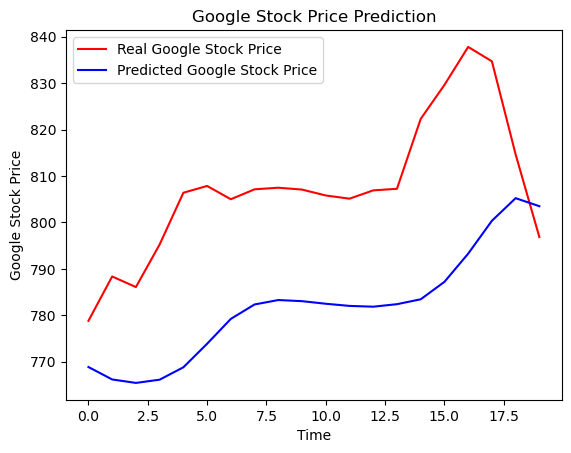

In [34]:
# Visualizing the results  
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')  
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')  
plt.title('Google Stock Price Prediction')  
plt.xlabel('Time')  
plt.ylabel('Google Stock Price')  
plt.legend()  
plt.show()  

From the above input, we can see that we have the real Google stock price in red and our predicted Google stock price in blue. We also get a comparison of the real and the predicted Google stock prices for the whole month of January 2017. We have got the real Google stock price from the verified financial sources from the web. However, the predictions are coming from the RNN model that we just implemented.

We can see in some parts our predictions are lagging behind the actual values. We can clearly see a big spike, like a stock time singularity, which is not followed by the predictions, and it is completely normal. Out model just lags behind because it cannot react to fast, nonlinear changes.

The spike in the image is the stock time irregularity, is indeed a fast, nonlinear change to which our model cannot react properly, but that's totally fine because according to the Brownian Motion Mathematical Concept in financial engineering, the future variations of the stock price are independent of the past. And, therefore, the future variation that we see around the spike, well it is a variation that is indeed totally independent from the previous stock prices.

But on the other hand, there is good news that out model reacts okay to smooth changes that happen on the Real Google Stock Price except for the spikes to which our model cannot react, but other than that, our Recurrent Neural Network reacts pretty well to these smooth changes.

So, it can be concluded that in the parts of the predictions containing some spikes, well our predictions lag behind the actual values because our model cannot react to fast, nonlinear changes, whereas on the other hand, for the parts of the predictions containing smooth changes, well our model predicts pretty well as well as manages to follow the upward and downward trends. It manages to follow the upward trend, the stable trend, and again the upward trend on the Predicted Google Stock Price. Then there is a downward trend in the last financial days of January, and it started to capture it. So, we can say it make really good results that actually make pretty much sense in spite of spikes.